# Imports

In [1]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from data_utils.datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier, TemporalConvRNN, Seq2SeqRNN
import data_utils.augmentations as augs
import csv

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [2]:
data_filename = os.path.expanduser('/Users/wangmaidou/Documents/Lang BCI/BCI Code/seq2seq_RNN/pt_decoding_data_S62.pkl')
# data_filename = ('../data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [4]:
pt_data.keys()

dict_keys(['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62'])

In [5]:
pt_data['S14'].keys()

dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])

In [6]:
pt_data['S14']['y_full_phon'].shape

(144, 3)

In [7]:
single_trial_single_chan_X1 = pt_data['S14']['X1'][0][:,0]
single_trial_single_chan_X2 = pt_data['S14']['X2'][0][:,0]
single_trial_single_chan_X3 = pt_data['S14']['X3'][0][:,0]

import numpy as np

def find_best_overlap(a, b, min_overlap=20, tol=0.9):
    """
    Find the best overlap length between the end of a and start of b
    using correlation. Returns the overlap length and correlation.
    
    Args:
        a, b: numpy arrays (1D sequences)
        min_overlap: minimum length of overlap to consider
        tol: correlation threshold (0–1)
    """
    max_overlap = min(len(a), len(b))
    best_corr, best_len = -1, 0

    for i in range(min_overlap, max_overlap + 1):
        seg_a = a[-i:]
        seg_b = b[:i]
        corr = np.corrcoef(seg_a, seg_b)[0, 1]
        if corr > best_corr:
            best_corr, best_len = corr, i

    return best_len if best_corr >= tol else 0, best_corr


def merge_two(a, b, name_a="A", name_b="B", min_overlap=20, tol=0.9):
    """
    Merge two sequences by finding overlap using correlation.
    Returns merged sequence and overlap length.
    """
    overlap_len, corr = find_best_overlap(a, b, min_overlap=min_overlap, tol=tol)
    print(f"Overlap between {name_a} and {name_b}: {overlap_len} (corr={corr:.3f})")
    merged = np.concatenate([a, b[overlap_len:]])
    return merged, overlap_len


def merge_with_overlap(arrays, names=None, min_overlap=20, tol=0.9):
    """
    Recursively merge a list of sequences by correlation-based overlap.
    """
    if names is None:
        names = [f"X{i+1}" for i in range(len(arrays))]
    if len(arrays) == 1:
        return arrays[0], 0
    elif len(arrays) == 2:
        return merge_two(arrays[0], arrays[1], names[0], names[1], 
                         min_overlap=min_overlap, tol=tol)
    else:
        merged_first_two, _ = merge_two(arrays[0], arrays[1], 
                                        names[0], names[1], 
                                        min_overlap=min_overlap, tol=tol)
        return merge_with_overlap([merged_first_two] + arrays[2:], 
                                  [names[0] + names[1]] + names[2:], 
                                  min_overlap=min_overlap, tol=tol)

# Example usage
merged_signal, overlap_len = merge_with_overlap([
    single_trial_single_chan_X1,
    single_trial_single_chan_X2,
    single_trial_single_chan_X3
])


Overlap between X1 and X2: 170 (corr=0.998)
Overlap between X1X2 and X3: 159 (corr=0.998)


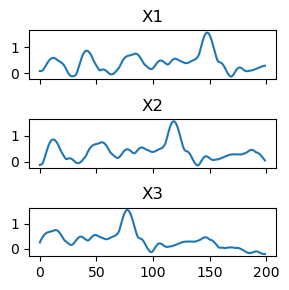

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(3, 3), sharex=True)

axs[0].plot(single_trial_single_chan_X1)
axs[0].set_title("X1")

axs[1].plot(single_trial_single_chan_X2)
axs[1].set_title("X2")

axs[2].plot(single_trial_single_chan_X3)
axs[2].set_title("X3")

plt.tight_layout()
plt.show()

Merged signal has length 271.


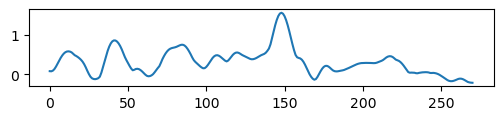

In [9]:
plt.figure(figsize=(6, 1))
plt.plot(merged_signal)

print(f'Merged signal has length {len(merged_signal)}.')

In [10]:
pt = 'S14'
p_ind = 1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(144, 200, 111), (144,), (144, 3)]
[[(148, 200, 111), (148,), (148, 3)], [(151, 200, 63), (151,), (151, 3)], [(46, 200, 149), (46,), (46, 3)], [(151, 200, 74), (151,), (151, 3)], [(137, 200, 144), (137,), (137, 3)], [(141, 200, 171), (141,), (141, 3)], [(178, 200, 201), (178,), (178, 3)]]


In [11]:
tar_data[1]

array([9, 8, 3, 2, 2, 8, 4, 2, 6, 1, 8, 4, 8, 8, 8, 2, 4, 2, 4, 7, 7, 1,
       1, 1, 9, 8, 1, 3, 3, 6, 8, 7, 4, 6, 9, 4, 5, 3, 3, 5, 9, 2, 6, 7,
       7, 4, 8, 2, 8, 5, 1, 7, 6, 3, 4, 9, 9, 1, 5, 1, 8, 1, 8, 4, 9, 3,
       4, 3, 7, 1, 2, 6, 2, 8, 5, 8, 7, 2, 8, 5, 2, 3, 3, 7, 1, 3, 6, 4,
       7, 4, 4, 8, 8, 1, 6, 8, 8, 8, 2, 4, 5, 7, 2, 7, 4, 5, 1, 3, 7, 4,
       6, 3, 2, 8, 6, 9, 7, 8, 6, 5, 1, 5, 1, 2, 3, 4, 9, 3, 1, 1, 4, 2,
       4, 4, 2, 9, 3, 9, 7, 8, 3, 6, 4, 8], dtype=uint8)

In [12]:
# fold_data_path = '.'

fs = 200 # Hz
# augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
augmentations = [augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long().unsqueeze(1) - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
# pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long().unsqueeze(1) - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[2]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]  # for seq2seq RNN
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

# create the data module
batch_size = 500
n_folds = 20
val_size = 0.1

# context_prefix = 'ptSpecific'
context_prefix = 'pooled'
fold_data_path = os.path.expanduser('/Users/wangmaidou/Documents/Lang BCI/BCI Code/cross_patient_speech_decoding/aligned_decoding/nn_models/RNN folder/') + context_prefix

# dm = SimpleMicroDataModule(data, labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))
## modification of labels for seq2seq RNN ###
# dm = SimpleMicroDataModule(data, align_labels, batch_size=batch_size, folds=n_folds,
#                            val_size=val_size, augmentations=augmentations, data_path=fold_data_path)


# # dm = AlignedMicroDataModule(data, labels, align_labels, pool_data, AlignCCA,
# #                             batch_size=batch_size, folds=n_folds, val_size=val_size,
# #                             augmentations=augmentations, data_path=fold_data_path)
dm = AlignedMicroDataModule(data, align_labels, align_labels, pool_data, AlignCCA,
                            batch_size=batch_size, folds=n_folds, val_size=val_size,
                            augmentations=augmentations, data_path=fold_data_path)
dm.setup()

KeyboardInterrupt: 

In [42]:
dm.train_dataloader().dataset.tensors[1].shape

torch.Size([4296, 3])

# Define model

In [43]:
from pytorch_lightning.utilities.model_summary import summarize


gclip_val = 0.5

##### CNN TRANSFORMER #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# d_model = 128
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_head = 8
# num_layers = 2
# dim_fc = 64
# # dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# tform_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate)


##### Temporal CNN classifier #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
#                            cnn_dropout, learning_rate, l2_reg)


##### Temporal CNN GRU #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# n_filters = 100
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_layers = 1
# hidden_size = 500
# dim_fc = [128, 64]
# cnn_dropout = 0.3
# rnn_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# activ = True

# sum_model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
#                             kernel_size, dim_fc, stride, padding, cnn_dropout,
#                             rnn_dropout, learning_rate, l2_reg)



##### Seq2Seq RNN #####
# model parameters
in_channels = data.shape[-1] # 111
num_classes = 9
n_filters = 100
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 50  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_enc_layers = 2
n_dec_layers = 1
hidden_size = 500
cnn_dropout = 0.3
rnn_dropout = 0.3
learning_rate = 1e-4
l2_reg = 1e-5
activ = False
model_type = 'gru'

sum_model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                       n_dec_layers, kernel_size, stride, padding, cnn_dropout,
                       rnn_dropout, model_type, learning_rate, l2_reg)

print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | eval 
1 | temporal_conv | TemporalConv     | 111 K  | train
2 | encoder       | EncoderRNN       | 6.3 M  | train
3 | decoder       | DecoderRNN       | 1.5 M  | train
-----------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.743    Total estimated model params size (MB)
11        Modules in train mode
1         Modules in eval mode


/opt/anaconda3/envs/bci/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [44]:
data.shape[-1]

111

# Train model

In [45]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [46]:
# instantiate the trainer
max_epochs = 500
# es_pat = max_steps // 20
# max_steps = 500
es_pat = 50
warmup = 100
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [47]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [48]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [49]:
acc_dir = os.path.expanduser('~/workspace/transformer_data/accs/')

# train the model
n_iters = 20
iter_accs = []
for i in range(n_iters):
    print(f'##### Setting up data module for iteration {i+1} #####')
    dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        # if fold > 1:
        #     break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        # model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
        #                            cnn_dropout, learning_rate, l2_reg, activation=activ)
        # model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                                # kernel_size, dim_fc, stride, padding, cnn_dropout,
                                # rnn_dropout, learning_rate, l2_reg, activation=activ,
                                # decay_iters=max_epochs)
        model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                           n_dec_layers, kernel_size, stride, padding, cnn_dropout, rnn_dropout, model_type,
                           learning_rate, l2_reg, activation=activ, decay_iters=max_epochs)
        
        # model.current_fold = fold
        callbacks = [
            # ModelCheckpoint(monitor='val_loss', mode='min'),
            ModelCheckpoint(monitor='val_acc', mode='max'),
            # EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            max_epochs=max_epochs,
                            # max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print(trainer.callback_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    with open(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs_iter{i+1}.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(iter_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)
with open(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerows(iter_accs)
np.save(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.npy'), np.array(iter_accs))

##### Setting up data module for iteration 1 #####


/opt/anaconda3/envs/bci/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# View results

In [50]:
pt = 'S14'
acc_dir = os.path.expanduser('~/workspace/transformer_data/accs/')
context_prefix = 'pooled'

In [51]:
iter_accs = np.load(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.npy'))
print(iter_accs.shape)
print(iter_accs.mean(axis=1))
print(iter_accs.mean())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangmaidou/workspace/transformer_data/accs/pooled/S14_pooled_seq2seq_rnn_accs.npy'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
# plt.boxplot(iter_accs.mean(axis=1))
sns.boxplot(data=iter_accs.mean(axis=1))
sns.swarmplot(data=iter_accs.mean(axis=1), color='black')
# sns.boxplot(data=iter_accs.T)
# sns.swarmplot(data=iter_accs.T, color='black')
plt.axhline(y=1/9, color='gray', linestyle='--')
plt.ylim(0, None)
plt.show()